<a href="https://colab.research.google.com/github/daivik05/Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation/blob/main/plant2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub

from keras.applications import MobileNetV2
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
!pip install tensorflow

In [ ]:
repo_name = 'Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation'
repo_url = f'https://github.com/daivik05/Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation'  # Replace your_username
!git clone $repo_url


Cloning into 'Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation'...
remote: Enumerating objects: 4733, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4733 (delta 0), reused 4 (delta 0), pack-reused 4729
Receiving objects: 100% (4733/4733), 1.59 GiB | 30.41 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (4718/4718), done.


In [ ]:
project_dir = f'/content/{repo_name}'
%cd $project_dir

/content/Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation


In [ ]:
train_path = 'train/'

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
 train_path,
    batch_size=256,
  image_size=(224,224), shuffle=True
)

Found 4715 files belonging to 3 classes.


In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 3773 images belonging to 3 classes.


In [ ]:
for img, label in train_generator:
    print("Training Batch Shapes:", img.shape, label.shape)
    break

train_generator.class_indices
len(train_data.class_names)


Training Batch Shapes: (32, 224, 224, 3) (32, 3)


3

In [ ]:
class_labels = train_data.class_names
class_labels

['corn_leaf', 'rice_leaf_diseases', 'wheat_leaf']

In [ ]:
for img, label in train_generator:
    #print(img)
    print(label)
    break

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
label[10]


array([1., 0., 0.], dtype=float32)

In [ ]:

len(class_labels)

3

In [ ]:
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False, weights='imagenet')


for layer in base_model.layers:
    layer.trainable = False

classification_input = Input(shape=(224, 224, 3), name='classification_input')
percentage_input = Input(shape=(224, 224, 3), name='percentage_input')


classification_output = base_model(classification_input)
classification_output = GlobalAveragePooling2D()(classification_output)
classification_output = Dense(100, activation='relu')(classification_output)
classification_output = Dense(100, activation='relu')(classification_output)
classification_output = Dense(len(class_labels), activation='softmax')(classification_output)

percentage_output = base_model(percentage_input)
percentage_output = GlobalAveragePooling2D()(percentage_output)
percentage_output = Dense(100, activation='relu')(percentage_output)
percentage_output = Dense(100, activation='relu')(percentage_output)
percentage_output = Dense(1, activation='sigmoid')(percentage_output)


classification_output_flat = Flatten()(classification_output)


combined_output = Concatenate()([classification_output_flat, percentage_output])


combined_model = Model(inputs=[classification_input, percentage_input], outputs=combined_output)


combined_model.compile(optimizer='adam',
                       loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],  # Define losses for classification and percentage estimation
                       loss_weights=[1.0, 0.5],  # Adjust loss weights as needed
                       metrics=['accuracy'])

combined_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 classification_input (Inpu  [(None, 224, 224, 3)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['classification_input[0][0]',
 tional)                                                             'percentage_input[0][0]']    
                                                                                                  
 percentage_input (InputLay  [(None, 224, 224, 3)]        0         []                            
 er)                                                                                        

In [ ]:
steps_per_epoch = len(train_generator)

model.add(Dense(len(class_labels), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    batch_size=256,
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/10
118/118 [==============================] - 221s 2s/step - loss: 0.8154 - accuracy: 0.8882
Epoch 2/10
118/118 [==============================] - 217s 2s/step - loss: 0.6411 - accuracy: 0.8882
Epoch 3/10
118/118 [==============================] - 216s 2s/step - loss: 0.5272 - accuracy: 0.8882
Epoch 4/10
118/118 [==============================] - 219s 2s/step - loss: 0.4597 - accuracy: 0.8882
Epoch 5/10
118/118 [==============================] - 216s 2s/step - loss: 0.4283 - accuracy: 0.8882
Epoch 6/10
118/118 [==============================] - 214s 2s/step - loss: 0.4172 - accuracy: 0.8882
Epoch 7/10
118/118 [==============================] - 216s 2s/step - loss: 0.4135 - accuracy: 0.8882
Epoch 8/10
118/118 [==============================] - 211s 2s/step - loss: 0.4121 - accuracy: 0.8882
Epoch 9/10
118/118 [==============================] - 206s 2s/step - loss: 0.4114 - accuracy: 0.8882
Epoch 10/10
118/118 [==============================] - 207s 2s/step - loss: 0.4111 - accura

In [71]:

model.save("plant_disease_model.h5")

In [ ]:
loss,acc = model.evaluate(train_generator)
print("Loss on Train data:",loss)
print("Accuracy on Train data:",acc)

118/118 [==============================] - 209s 2s/step - loss: 0.4109 - accuracy: 0.8882
Loss on Train data: 0.4109236001968384
Accuracy on Train data: 0.8881526589393616


In [70]:
acc = history.history["accuracy"]
loss = history.history["loss"]

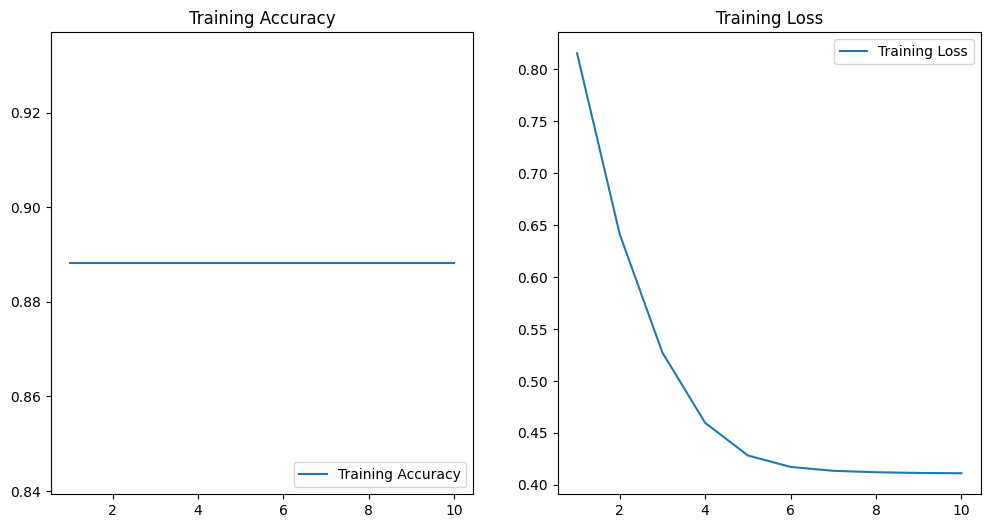

In [69]:
acc = history.history["accuracy"]
loss = history.history["loss"]

EPOCHS = len(acc)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), acc, label="Training Accuracy")
plt.legend(loc="lower right")
plt.title("Training Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), loss, label="Training Loss")
plt.legend(loc="upper right")
plt.title("Training Loss")
plt.show()


In [64]:

class_labels = ['corn_leaf', 'rice_leaf_diseases', 'wheat_leaf']
disease_labels = {
    'corn_leaf': ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'],
    'rice_leaf_diseases': ['Bacterial leaf blight', 'Brown spot', 'Leaf smut'],
    'wheat_leaf': ['wheat_leaf_Healthy', 'wheat_leaf_septoria', 'wheat_leaf_stripe_rust']
}


In [67]:

predictions = combined_model.predict([img_array, img_array])
class_probabilities = predictions[0][0]
percentage_affected = predictions[0][1]

class_index = np.argmax(class_probabilities)
predicted_crop_type = class_labels[class_index]


is_affected = "Affected" if percentage_affected > 0.5 else "Not Affected"


print("Predicted Crop Type:", predicted_crop_type)
print("Affected Status:", is_affected)
print("Class Probabilities:", class_probabilities)
print("Predicted Percentage of Leaf Affected:", percentage_affected)


1/1 [==============================] - 0s 70ms/step
Predicted Crop Type: corn_leaf
Affected Status: Not Affected
Class Probabilities: 0.5241344
Predicted Percentage of Leaf Affected: 0.41701546


In [72]:
from google.colab import files

# Download the saved model
files.download("plant_disease_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>